<a href="https://colab.research.google.com/github/alihuss1017/LSTM-Weather-Prediction/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/alihuss1017/LSTM-Weather-Prediction.git

Cloning into 'LSTM-Weather-Prediction'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 31 (delta 12), reused 5 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (31/31), 102.12 KiB | 1.04 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
cd LSTM-Weather-Prediction

/content/LSTM-Weather-Prediction


## Installing Optuna and Setting Up Wandb



In [ ]:
!pip install optuna
!pip install optuna-integration[wandb]

In [ ]:
!wandb login

In [ ]:
import pandas as pd
df = pd.read_csv('data/seattle-weather.csv')

## Checking for Null Values and Duplicates

In [ ]:
print(f'''Number of null values:\n{df.isnull().sum()}\n\nNumber of duplicated rows: {df.duplicated().sum()}''')

Number of null values:
date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

Number of duplicated rows: 0


## Setting DateTime as Index

In [ ]:
df = df.set_index(df["date"])
df = df.drop('date', axis = 1)


## One-Hot Encoding Categorical Features:

In [ ]:
df_encoded = pd.get_dummies(df, columns = ['weather'])

## Applying Z-Score Normalization on Numerical Features

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
columns_to_normalize = df_encoded.select_dtypes(include='float').columns.tolist()

df_encoded[columns_to_normalize] = scaler.fit_transform(df_encoded[columns_to_normalize])

## Defining the PyTorch Custom Dataset Class

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class WeatherDataset(Dataset):

  def __init__(self, data_df, seq_len):
    self.data = data_df
    self.seq_len = seq_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    cols_to_cast = self.data.select_dtypes(include = ['object', 'bool']).columns.tolist()
    for col in cols_to_cast:
      self.data[col] = self.data[col].astype('int')

    x = torch.tensor(self.data.iloc[idx:idx+self.seq_len].values, dtype = torch.float32)
    y = torch.tensor(self.data['temp_max'].iloc[idx+self.seq_len+1], dtype = torch.float32)

    return x, y


## Defining Model

In [ ]:
import torch.nn as nn

input_features = 9

class lstmModel(nn.Module):
  def __init__(self, hidden_features, num_layers):
    super().__init__()

    self.lstm = nn.LSTM(input_size = input_features,
                        hidden_size = hidden_features, num_layers = num_layers,
                        batch_first = True)
    self.fc = nn.Linear(hidden_features, 1)

  def forward(self, x):
    out, [h, c] = self.lstm(x)
    return self.fc(h[-1])


## Model Debugging

In [ ]:
model = lstmModel(32, 2)
model.eval()
with torch.no_grad():
  print(f'Output: {model(torch.rand((5, 9)))}')

Output: tensor([-0.2511])


## Configuring Device

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

print(f'Device: {device}')

Device: cuda


## Training Function

In [ ]:
def train(model, train_loader, optimizer, loss_fn):
  model.train()
  total_loss = 0
  for X, y in train_loader:
    optimizer.zero_grad()

    X, y = X.to(device), y.to(device)
    y_hat = model(X)

    loss = loss_fn(y, y_hat)
    total_loss += loss.item()

    loss.backward()
    optimizer.step()

  return total_loss / len(train_loader)


## Evaluating Function

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def eval(model, val_loader, loss_fn):
  total_loss = 0
  model.eval()

  with torch.no_grad():
    for X, y in val_loader:
      X, y = X.to(device), y.to(device)
      y_hat = model(X)

      loss = loss_fn(y, y_hat)
      total_loss += loss.item()

  return total_loss / len(val_loader)




## Optuna Hyperparameter Tuning + Wandb Experiment Tracking

In [ ]:
import optuna
from optuna.integration.wandb import WeightsAndBiasesCallback
import wandb
from torch.utils.data import Subset
import torch.optim as optim


def objective(trial):

  seq_len = trial.suggest_int('seq_len', 5, 20)
  batch_size = trial.suggest_int('batch_size', 16, 64)
  hidden_features = trial.suggest_int('hidden_features', 32, 128)
  num_layers = trial.suggest_int('num_layers', 1, 3)
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
  num_epochs = trial.suggest_int('num_epochs', 5, 10)
  loss_fn = nn.MSELoss()

  wandb.init(
      project="lstm-weather",
      config={
          'seq_len': seq_len,
          'batch_size': batch_size,
          'hidden_features': hidden_features,
          'num_layers': num_layers,
          'lr': lr,
          'num_epochs': num_epochs
      }
  )

  dataset = WeatherDataset(data_df = df_encoded, seq_len = seq_len)
  train_len = int(0.7 * len(dataset))
  val_len = int(0.15 * len(dataset))

  train_data = Subset(dataset, range(train_len))
  val_data = Subset(dataset, range(train_len, train_len + val_len))

  train_loader = DataLoader(train_data, batch_size = 32, num_workers = 2, drop_last = True)
  val_loader = DataLoader(val_data, batch_size = 32, num_workers = 2, drop_last = True )

  model = lstmModel(hidden_features = hidden_features, num_layers = num_layers).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)

  for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, loss_fn)
    val_loss = eval(model, val_loader, loss_fn)

    wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss})

  return val_loss



In [ ]:
wandb_callback = WeightsAndBiasesCallback(metric_name="val_loss", wandb_kwargs={'project': 'lstm-weather'})

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, callbacks=[wandb_callback])

best_trial = study.best_trial

## Displaying the Best Parameters

In [ ]:
for key, val in best_trial.params.items():
  print(f"{key}: {val}")

seq_len: 20
batch_size: 19
hidden_features: 112
num_layers: 1
lr: 0.00021495843195084815
num_epochs: 5


In [ ]:
seq_len, batch_size, hidden_features, num_layers, lr, num_epochs = best_trial.params.values()

## Computing Mean and Standard Deviation for Inference Purposes

In [ ]:
df_test = df_encoded.iloc[len(df_encoded) - int(0.15*len(df_encoded)):len(df_encoded)]

mu, sigma = df_test['temp_max'].mean(), df_test['temp_max'].std()

## Training the Model on the Best Hyperparameters and Model Parameters

In [ ]:
dataset = WeatherDataset(data_df = df_encoded, seq_len = seq_len)
train_len = int(0.7 * len(dataset))
val_len = int(0.15 * len(dataset))

train_data = Subset(dataset, range(train_len))
test_data = Subset(dataset, range(train_len + val_len, len(dataset)))

train_loader = DataLoader(train_data, batch_size = 32, num_workers = 2, drop_last = True)
test_loader = DataLoader(test_data, batch_size = 32, num_workers = 2, drop_last = True)

model = lstmModel(hidden_features = hidden_features, num_layers = num_layers).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

model.train()

for epoch in range(num_epochs):
  for X, y in train_loader:
    optimizer.zero_grad()

    X, y = X.to(device), y.to(device)
    y_hat = model(X)

    loss = loss_fn(y, y_hat)

    loss.backward()
    optimizer.step()


## Evaluating Performance on Test Set and Plotting Predictions

Testing MSE: 0.3286851570010185


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


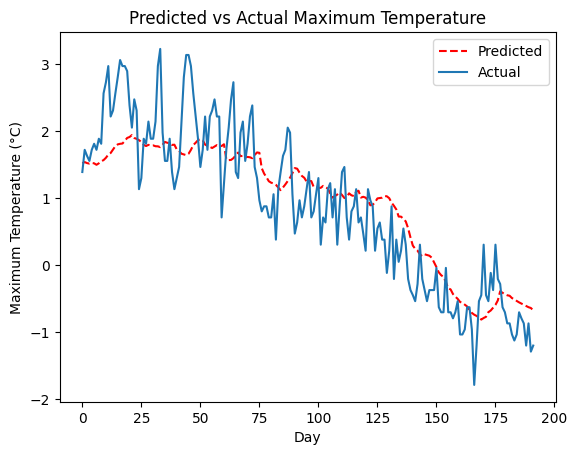

In [ ]:
predicted = []
actual = []
total_loss = 0

model.eval()

with torch.no_grad():
  for X, y in test_loader:
    X, y = X.to(device), y.to(device)
    y_hat = model(X)

    loss = loss_fn(y, y_hat)
    total_loss += loss.item()

    predicted.append(y_hat.cpu())
    actual.append(y.cpu())

  print(f"Testing MSE: {total_loss / len(test_loader)}")


plt.figure()
plt.title("Predicted vs Actual Maximum Temperature")
plt.xlabel("Day")
plt.ylabel("Maximum Temperature (°C)")
plt.plot(np.array(predicted).flatten() * sigma + mu, c = 'r', linestyle = "--", label = "Predicted")
plt.plot(np.array(actual).flatten() * sigma + mu, label = "Actual")
plt.legend()